# Fraud Detection Using Markov Chain Monte Carlo
This this workshop we will look at how Markov Chain Monte Carlo methods can be used to identify fraud by detecting subtle changes in activity.
This technique requires far less data than typical fraud detection algorithms, enabling continual fraud monitoring in a data-sparse environment. <br><br>
This workshop is based on Chapter 1 of "Probabilistic-Programming-and-Bayesian-Methods-for-Hackers" by Cam Davidson Pilson. 

## An Introduction To Trading
One of the most lucrative and high-pressure jobs in the finance industry is that of a market trader. A trader will hold a portfolio of millions, potentially billions, of their client's money. They will use a combination of complex trading algorithms and in-depth market knowledge to decide when to buy, or sell certain items. These items are usually one (or often many) of the following: <br>
Currencies, such as Great British Pounds, US Dollars, or Japanese Yen. These are often bought and sold multiple times per day, with traders making money from sudden swings back and forth. <br>
Stocks/Shares, which are small amounts of ownership in a listed company, such as BAE Systems, or Lloyds Banking Group. These can be traded daily, as with currencies, but are usually held for longer periods (6 months or more) to benefit from the long term growth of a company. <br>
Commodities, such as Gold, Silver, or Copper. These can be traded either rapidly or over long periods, depending on the appetite of the trader and the type of commodity. For example, Oil is very volatile and hard to predict long-term, so is often day-traded. <br>
Derivatives, a more advanced financial product based on estimating the future value of something. These can be held long term or rapidly traded, depending on the underlying financial product. <br> <br>
This work does not go into the ins and outs of these different types of product, however it is worth noting the rate of trading usually associated with each category.

## Insider Trading
Trading is, ultimately, betting. A trader will "long" an item if they believe it will go up in value. This is where they might buy a barrel of oil for £50, in the belief that later they can sell it for £100. Traders can also "short" an item if they believe it will go down in value. Shorting is where they borrow some stock from someone, and sell the stock to somebody else. They will then later buy some stock back to return to the original owner, hoping that the stock has lost value. Shorting is higher risk than longing. This is because the losses are, in theory, unlimited with a short, but limited with a long. If a stock is long at £100 then if the stock goes bust, the owner has lost £100 but no more. If a stock is shorted at £100 but then goes up 10x in value then the short holder will have to pay £1000 to replace the borrowed stock! It is also far more lucrative, and more prone to insider trading. <br> <br>
Insider trading is the process by which a trader will use information about a company that is not in the public domain, and use this to their advantage. For example, a trader may have a friend who works for WeBuyAnyZebra.com who tells him that WeBuyAnyZebra have a serious outbreak of Zebra measles. When this is made public the trader knows that it will dramatically decrease the value of their stock, so he places a sizeable short. The next day, an investigation reveals the outbreak to the public, the stock value drops and the trader makes a pretty penny. This practice is highly illegal. <br> <br>
Insider trading doesn't just have to be a one off, however. Take for example a manufacturing company which, when receiving orders, buy in the required materials. Traders will watch carefully the amount of material ordered, as more material may indicate good performance and less material may be a sign of trouble. Knowing when and how much will be ordered could be a seriously lucrative info stream for a trader.

It is also quite difficult to detect without sophisticated surveillance programmes in place, and even these are not 100% effective.

Insider trading is a serious problem because not only does it destabilise markets but it also can encourage active sabotage of a company. It is hard for any one employee to dramatically raise the value of a company's stock, but an employee strategically allowing a data breach, or violating a major law, can predictably drop the company's value. For this reason, finding ways of detecting insider trading is extremely valuable to companies, law enforcement, and the economy as a whole.

## The Scenario
A bank has received intelligence that indicates that one of their small group of traders may have access to a stream of insider information allowing them to engage in illegal insider trading. Unfortunately the intelligence was vague - they do not know which trader has been contacted, which trades this relates to, and they only know the information stream was set up in the past 3 months! They need to get this sorted ASAP and have agreed to pay you a significant amount of money if you can help out. <br><br>
Although the bank have vast amounts of data on the trades and personal information of all of their traders it will take several weeks to get the appropriate paperwork sorted for them to be allowed to share that information with you. Because time is critical (if the trader gets wind they've been rumbled they might suddenly work harder to cover their tracks) they have agreed to send you a data set with a handful of columns in the hope that you can point them in the right direction.

## Required Packages
This exercise uses the Pandas, Matplotlib, SciPy, and pymc3 packages. The workshop assumes that you have already completed Phil Goddard's section and so does not go into great detail about the use of the Pandas, Matplotlib and SciPy packages. We will explore the pymc3 package when we get to it.

In [ ]:
!pip install pymc3

In [2]:
# Lets start by importing all of the packages we will require in this workshop
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import random

import pymc3 as pm
import theano.tensor as tt
import scipy.stats as stats

%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Exploring The Data

Import and take a look through the data to see what we're working with. This is also a good time to see if you can identify at the outset who might be a candidate for the insider trader.

In [3]:
# Import the data from https://raw.githubusercontent.com/CoolRosh/GradnetRosh/master/trades.csv
url = "https://raw.githubusercontent.com/CoolRosh/GradnetRosh/master/trades.csv"
received_data = pd.read_csv(url, index_col = 0)

In [4]:
# Inspect the data to see what you have using the info method
received_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 700 entries, 0 to 99
Data columns (total 4 columns):
Day       700 non-null int64
Name      700 non-null object
Trades    700 non-null int64
Type      700 non-null object
dtypes: int64(2), object(2)
memory usage: 27.3+ KB


In [4]:
# What is the head like?
received_data.head()

,Unnamed: 0,Day,Name,Trades,Type
0,0,1,Barry Gibb,11,Commodities
1,1,2,Barry Gibb,10,Commodities
2,2,3,Barry Gibb,11,Commodities
3,3,4,Barry Gibb,10,Commodities
4,4,5,Barry Gibb,10,Commodities


It looks like the bank have given us a pretty limited dataset - only 4 columns. The day in the range, trader names (which have been anonymised), the number of trades made that day, and the type of trade desk they were trading from. How many different traders are we looking at?

In [5]:
# Put the data into sets to see what names we have
trader_names = sorted(list(set(received_data["Name"])))
trader_names

['Barry Gibb',
 'Black Widow',
 'Captain America',
 'Iron Man',
 'Liam Neeson',
 'Maurice Gibb',
 'Robin Gibb']

From the above we should now be able to see how many traders there are. So one of these traders is our bad guy? This isn't a very rich data set, so there aren't many relationships we can explore to try and identify this insider trading. To help us decide what would be worth looking for lets have a deeper look at Barry Gibb to understand what his trade history looks like.

<Container object of 100 artists>

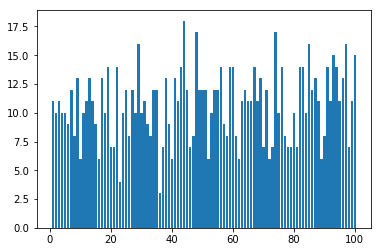

In [6]:
# Try plotting a bar chart to see what Barry's trading history looks like - plot Trades against Day
plt.bar(received_data.loc[received_data["Name"]== "Barry Gibb"]["Day"]
         , received_data.loc[received_data["Name"]== "Barry Gibb"]["Trades"])

Lets assume that when the trader gains access to the information stream that their trading behaviour changes, i.e. they start to trade more frequently (or less frequently). Lets try plotting the different traders against each other.

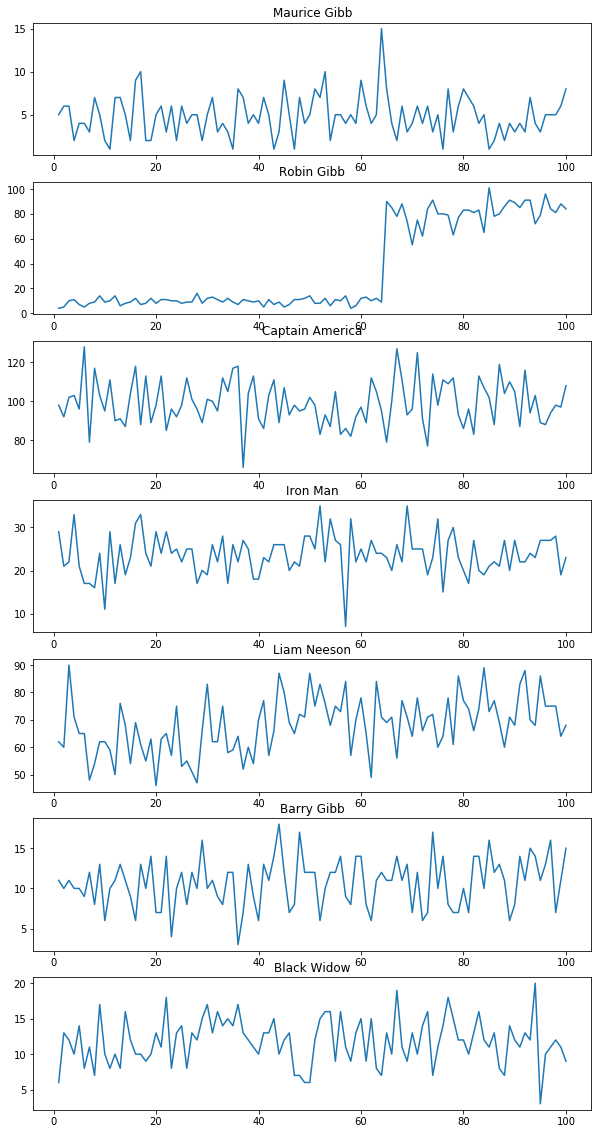

In [7]:
plt.figure(figsize=(10,20))
for i in range(1,8):
    plt.subplot(7,1,i)
    #Put a line plot in here that looks at the trader names in turn - again plot Trades against Day
    plt.plot(received_data.loc[received_data["Name"] == trader_names[i-1]]["Day"]
         , received_data.loc[received_data["Name"] == trader_names[i-1]]["Trades"])
    plt.title(trader_names[i-1])

There is a clear difference in one of those trader's behaviour! That could be a significant finding. Before we go too far, lets investigate that specific trader in more detail. Set the type of trading to have different colours and plot this as a bar chart.

<Container object of 100 artists>

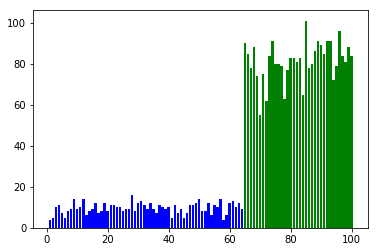

In [8]:
#This cell has been prepopulated because there are some odd things that need to be done
typecolours = colors = {'Commodities':'red', 'Stocks':'blue', 'Currency':'green'}
plt.bar(received_data.loc[received_data["Name"]== "Robin Gibb"]["Day"].reset_index(drop=True)
         , received_data.loc[received_data["Name"]== "Robin Gibb"]["Trades"].reset_index(drop=True)
         , color = received_data.loc[received_data["Name"]== "Robin Gibb"]["Type"].reset_index(drop=True).apply(lambda x: typecolours[x])
       )

## STOP HERE <br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

## Markov Chain Monte Carlo
To try to locate a potential change in behaviour we are going to use Markov Chain Monte Carlo. To explore this further it is useful to split the term down into its constituent parts: Markov Chains, and Monte Carlo. We first explore the Markov Chain element.

### Markov Chains
A Markov Chain is a statistical process where the expected result depends only on the current state of the variables involved, and not the history of the sequence. As an example, let us consider a game where the gambler bets £1 on the outcome of a coin flip. If the coin lands heads then the gambler loses their £1 stake. If the coin lands tails then the gambler wins £2. Consider the gambler currently has £15. The possible outcomes are that after the next coin flip the gambler has £14 (they bet, and lost) or the gambler has £16 (they bet and won). These two possible outcomes, £14 or £16, depend only on the current amount of money the gambler has. We do not gain any information from knowing that the gambler has won 5 times in a row, or that he has consistently won/lost/won/lost for 100 games. <br><br>
One other good example of a process that can be estimated by a Markov Chain is the stock market. The probability of a stock increasing or decreasing is related to the current value of the stock and the current state of the company. The probability of the stock increasing or decreasing does not relate to the previous movement of the stock - this is why it is so difficult to reliably make money from the stock market based on historical data alone.

#### Example Markov Chain Processes
There are several mathematical functions which produce Markov Chains. The following are an example of some of these functions: <br><br>

Random Walks - A movement in one direction or another with a given probability.
<br> E.g. Diffusion of gasses, Movement of stock market, Genetic Drift <br><br>

Poisson - Distributions relating to a random number of discrete events in a particular time period, with a given average. <br> E.g. Number of raindrops per second, Number of times a cannon fires before breaking, Number of pints of beer I drink per day <br><br>

Logistic Functions - Probability of an event occurring based on a particular measurement (i.e. only the current measurement and not previous ones).
<br> E.g. O-rings breaking as temperature decreases, Dying in a car crash based on speed at collision, Quitting a job based on time served


### Monte Carlo Processes
Monte Carlo modelling is a concept relatively familiar to many modellers within the physical sciences. An in depth knowledge is not required for this workshop, however the basics are covered here for anyone who has not yet had the chance to use them. <br><br>
Monte Carlo simulations can be used to calculate the results of integrals that are not otherwise analytically solvable. This is extremely useful for the physicist looking to solve complex quantum mechanics problems, or the statistician looking to solve many-variable stochastic problems. As an example of this, however, we eschew mathematics and turn to a more conceptually digestable example: the area taken up by a village. <br><br>
Imagine an ariel photograph of a village - an awkwardly shaped mess of twisting, turning roads and a poorly defined meandering border. How can we find the area the village takes up? We could try to overlay a grid and count occupied squares but this is inexact and computationally difficult. We could try to form an equation for the perimiter and then integrate - though the odds of this being analytic are exceptionally low. Instead, we use a Monte Carlo type routine. We create a completely random number for a x,y coordinate within the frame of the photograph. We add 1 to a running total of number of points we've generated. We then determine, via some criteria or other, whether or not the point is part of the village. If so, we also add 1 to a running total of in-village points. <br><br>
After we have generated a sizeable number of points, say 10,000, we will have to two totals: one equally 10,000 for the number of points, and one for the number of in-village points. Lets assume this is 1,337 points. This tells us that the fraction of points within the village, and thus a good approximation for the fraction of the photograph taken up by the village, is 0.1337. If we assume the ariel photograph covers a domain space of 5 square miles, we can say that the village covers approximately 0.6685 square miles. The more points we have, the more precise a measurement we can get.<br>

Lets have a look at an example of determining pi.

There are two equations we will use here to determine pi: x^2 + y^2 = r^2, area = pi*r^2.  <br>

We will generate some random datapoints, within the range of x and y between 0 and 1, and for each datapoint see if it satisfies the equation x^2 + y^2 < 1 (using a radius of 1). If so then we will add 1 to our hit total. After this we will have populated one quarter of a circle - we can multiply this by 4 to find out how much of a 2 by 2 square a radius 1 circle occupies. Knowing the area of this circle we can therefore use pi r^2 to determine pi (for r = 1 it is just the area of the circle.

In [9]:
#Create 10,000 random x and y points between 0 and 1
xpoints = []
ypoints = []
for i in range(10000):
    xpoints.append(random.uniform(0, 1))
    ypoints.append(random.uniform(0, 1))
    
#check which satisfy our equation
successes = []
for i in range(10000):
    successes.append(xpoints[i]**2 + ypoints[i]**2 < 1.0)
    
#count how many are true as a ratio of the total points (10,000)
ratioofcircle = successes.count(True) / 10000

#Multiply this ratio by 4 (to get 2*2)
piguess = ratioofcircle * 4

#see how close we are!
print(piguess)
    

3.148


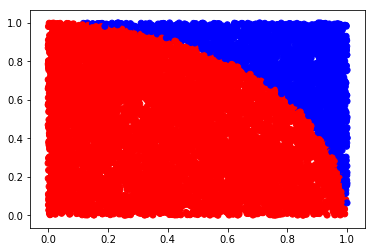

In [10]:
#Feel free to plot the points and whether they satisfy the equation to see what we've generated
picolours = []
for i in range(10000):
    if successes[i]:
        picolours.append('red')
    else:
        picolours.append('blue')
plt.scatter(xpoints, ypoints, color = picolours)

## STOP HERE <br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

### Putting This Together
Now that we have the concepts of both Markov Chains and Monte Carlo lets have a look at putting them together. This workshop is designed to be a demonstration of MCMC rather than a tutorial so the following explanation will be unavoidably hand-wavey. For a proper exploration the reader is directed to the book on which this tutorial is based. <br><br>
Let us assume we have the results of a process which has a certain distribution, focussed on a central mean, $\lambda$. For this lets choose a normal distribution. For simplicity we will fix the standard deviation to be 1, but have an unknown mean.

In [11]:
# Create a dataset that is a normal distribution with standard deviation of 1 and a mean of 5 
# (we will pretend we don't know the mean)

fake_measurements = np.random.normal(5.0, 1.0, 1000)

Plot this as a histogram to see how this looks!

(array([   3.,   22.,   60.,  149.,  241.,  231.,  181.,   82.,   25.,    6.]),
 array([ 1.78363455,  2.41069647,  3.0377584 ,  3.66482033,  4.29188226,
         4.91894418,  5.54600611,  6.17306804,  6.80012997,  7.4271919 ,
         8.05425382]),
 <a list of 10 Patch objects>)

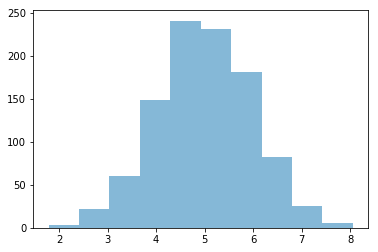

In [12]:
colours = ["#348ABD", "#A60628"]
plt.hist(fake_measurements, color=colours[0], alpha=0.6)

Now lets try and match a normal distribution to our data (remember we are pretending we don't know the mean). We can guess a mean and generate our own model of the data and then see how well it fits.

In [13]:
#create a data set guessing at a mean
simulated_results = np.random.normal(7.0, 1.0, 1000)

How does this compare to the actual measurements?

(array([   4.,   13.,   89.,  163.,  220.,  224.,  166.,   72.,   37.,   12.]),
 array([ 3.96453693,  4.56636282,  5.16818871,  5.7700146 ,  6.37184049,
         6.97366638,  7.57549227,  8.17731816,  8.77914405,  9.38096994,
         9.98279583]),
 <a list of 10 Patch objects>)

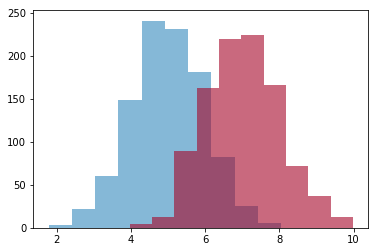

In [14]:
plt.hist(fake_measurements, color=colours[0], alpha=0.6)
plt.hist(simulated_results, color=colours[1], alpha=0.6)

This overlaps slightly but not perfect. How do we improve on this? Simple, we try again! But we note down the mean that we tried.

(array([   3.,   12.,   68.,  152.,  250.,  240.,  173.,   69.,   25.,    8.]),
 array([ 0.61566251,  1.269633  ,  1.92360348,  2.57757397,  3.23154445,
         3.88551493,  4.53948542,  5.1934559 ,  5.84742638,  6.50139687,
         7.15536735]),
 <a list of 10 Patch objects>)

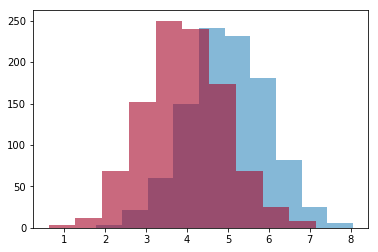

In [15]:
simulated_results = np.random.normal(4.0, 1.0, 1000)
plt.hist(fake_measurements, color=colours[0], alpha=0.6)
plt.hist(simulated_results, color=colours[1], alpha=0.6)

O.K, that looks a lot better, so lets move our estimate to the new guess. We now have a list of the guesses used (7.0, 4.0). Lets try another.

(array([  12.,   39.,  118.,  245.,  247.,  186.,   99.,   36.,   15.,    3.]),
 array([  6.28616817,   6.90974532,   7.53332246,   8.15689961,
          8.78047676,   9.4040539 ,  10.02763105,  10.65120819,
         11.27478534,  11.89836249,  12.52193963]),
 <a list of 10 Patch objects>)

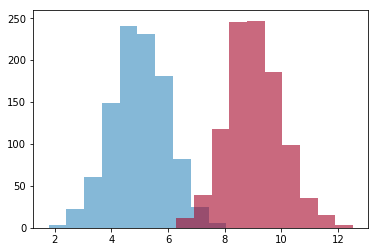

In [16]:
simulated_results = np.random.normal(9.0, 1.0, 1000)
plt.hist(fake_measurements, color=colours[0], alpha=0.6)
plt.hist(simulated_results, color=colours[1], alpha=0.6)

Way worse. So we stick with the old guess, right? Wrong. We'll say there is a *chance* that we will stick with our old guess, but we might actually move to the new guess. The probability of this jump depends on how much worse this guess is (i.e the ratio of how much they overlap). How do we know how much they're overlapping though? If only there were a way to integrate this difficult quantity... <br><br>
This is the core method behind MCMC that makes it work so well. Lets imagine we've run this sequence many times and generated the following list:

In [17]:
guess_history = [7.0, 4.0, 4.0, 5.0, 5.0, 9.0, 6.0, 5.0, 5.0, 4.0, 1.0, 3.0, 3.0, 6.0, 7.0, 5.0, 5.0, 2.0, 4.0, 5.0, 6.0, 5.0]

How does the histogram of this look?

4.8181818181818183

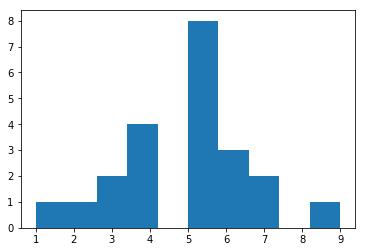

In [18]:
#Plot the histogram of the guess history and the mean
plt.hist(guess_history)
np.mean(guess_history)

Here we have an average estimate of the mean as being 4.8 - not far from the actual 5.0. More to the point we have a histogram of the mean, so we can actually say something about the *probability* that the mean is 4.8. We can see quite a solid peak here, which indicates we are quite certain that 4.8 is the mean. Compare this to a flat histogram (e.g. a histogram of number rolled on a dice) where we would find that although we may have a mean it would not be particularly pronounced.

## Catching Insider Trading With MCMC

We can now consider how we might find insider trading indicative behavioural change using MCMC. Let us assume that the number of trades is a random distribution. Choose a distribution (look at those we discussed earlier) that you think might approximate the number of trades made by a trader in a given day. This distribution will have some parameter, $\lambda$. We will now assume that for each trader, at some point in the 100 days, the behaviour changes - i.e. $\lambda_1$ becomes $\lambda_2$ at some time $\tau$. For each trader we can produce a histogram of when that change day, $\tau$, occurs.

In [6]:
# first remove X from the list, as we have already explained that behaviour change
suspect_traders = received_data.loc[received_data["Name"] != "Robin Gibb"]
remaining_names = sorted(list(set(suspect_traders["Name"])))
remaining_names

['Barry Gibb',
 'Black Widow',
 'Captain America',
 'Iron Man',
 'Liam Neeson',
 'Maurice Gibb']

We can create our model on one trader first as an example. First we will want to codify our model assumption of a $\lambda_1$, switching at $\tau$ to $\lambda_2$.

In [20]:
i = 0
trader_under_simulation = suspect_traders[suspect_traders["Name"] == remaining_names[i]]
# we want a sensible starting point for our distribution - 1 over the mean should work

with pm.Model() as model:
    alpha = 1.0 / trader_under_simulation["Trades"].mean()
    # then we can set the starting distrubtion of our lambda. We will use an exponential distribution for this
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)

    #We can also create an assumed initial distribution for tau. We will assume there is an equal probability of any day.
    #Upper is set to 99 as that is the max days - to allow for 0 indexing
    tau = pm.DiscreteUniform("tau", lower=0, upper=100)

In [21]:
with model:
    idx = np.arange(100)
    lambdain = pm.math.switch(tau > idx, lambda_1, lambda_2)

In [22]:
with model:
    observation = pm.Poisson("obs", lambdain, observed=trader_under_simulation["Trades"].as_matrix().astype(float))

Now everything is in place to run the model.

In [23]:
with model:
    
    step = pm.Metropolis()
    #The tune feature allows us to skip a certain number of values while the MCMC starts to track in random space
    trace = pm.sample(10000, tune=2500, step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2_log__]
>Metropolis: [lambda_1_log__]
The number of effective samples is smaller than 10% for some parameters.


In [24]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

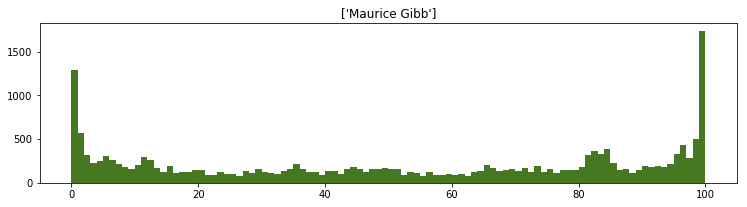

In [25]:
figsize(12.5, 10)
plt.subplot(311)
plt.hist(tau_samples, bins=100, alpha=1,
         label=r"$\tau$",
         color="#467821", rwidth=2.)
plt.title([remaining_names[i]])

It looks like it's working! What can we say about the graph above? Remember, this is attempting to show us the probability distribution of the behaviour change day, $\tau$.<br><br>

## STOP HERE <br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

O.K, lets put this into a loop and save these traces.

In [26]:
tau_found = []
trader_surveilled = []
for i in range(0,len(remaining_names)):
    trader_under_simulation = suspect_traders[suspect_traders["Name"] == remaining_names[i]]
    # we want a sensible starting point for our distribution - 1 over the mean should work
    if 'model' in locals():
        del model
        
    with pm.Model() as model:

        alpha = 1.0 / trader_under_simulation["Trades"].mean()
        
        lambda_1 = pm.Exponential("lambda_1", alpha)
        lambda_2 = pm.Exponential("lambda_2", alpha)
        tau = pm.DiscreteUniform("tau", lower=0, upper=100)
    
        idx = np.arange(100)
        lambdain = pm.math.switch(tau > idx, lambda_1, lambda_2)
        observation = pm.Poisson("obs", lambdain, observed=trader_under_simulation["Trades"].as_matrix().astype(float))
        step = pm.Metropolis()
        
        trace = pm.sample(10000, tune=2500, step=step)
        
        print(str(trader_under_simulation["Name"].iloc[1]) + " examined...")
    
    trader_surveilled.append(trader_under_simulation["Name"].iloc[1])
    tau_found.append(trace['tau'])

print("All traders analysed.")

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2_log__]
>Metropolis: [lambda_1_log__]
The number of effective samples is smaller than 10% for some parameters.


Maurice Gibb examined...


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2_log__]
>Metropolis: [lambda_1_log__]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Captain America examined...


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2_log__]
>Metropolis: [lambda_1_log__]
The number of effective samples is smaller than 10% for some parameters.


Iron Man examined...


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2_log__]
>Metropolis: [lambda_1_log__]
The number of effective samples is smaller than 10% for some parameters.


Liam Neeson examined...


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2_log__]
>Metropolis: [lambda_1_log__]
The number of effective samples is smaller than 10% for some parameters.


Barry Gibb examined...


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2_log__]
>Metropolis: [lambda_1_log__]
The estimated number of effective samples is smaller than 200 for some parameters.


Black Widow examined...
All traders analysed.


Now we can plot all of the traces to see whether anyone looks different!

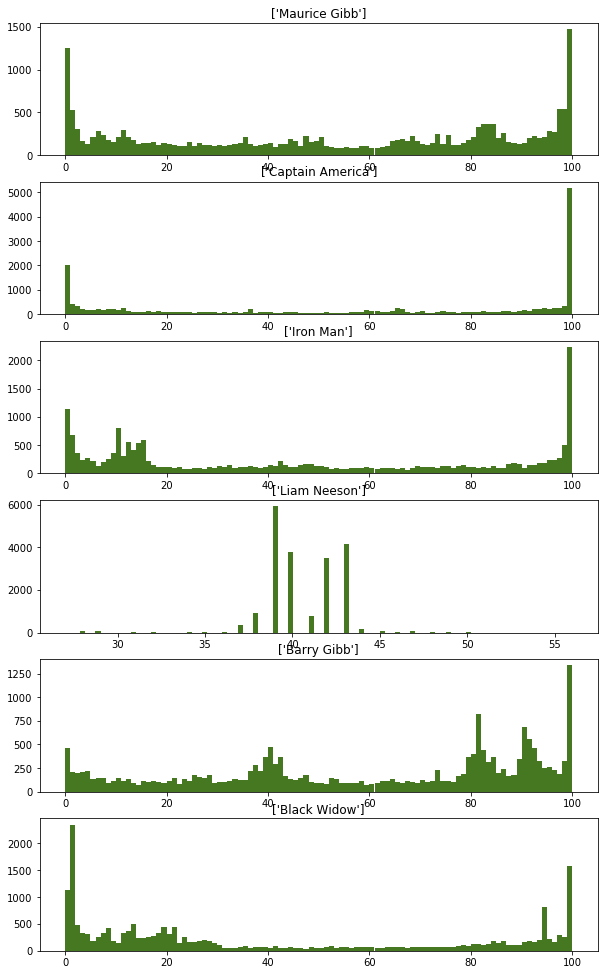

In [27]:
plt.figure(figsize=(10,20))
for i in range(0,len(remaining_names)):
    plt.subplot(7,1,i+1)
    plt.hist(tau_found[i], bins=100, alpha=1,
         label=r"$\tau$",
         color="#467821", rwidth=2.)
    plt.title([trader_surveilled[i]])

What are your conclusions on the above?

## END OF WORKSHOP